In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

#Hyperparameters
learning_rate = 0.0002
gamma         = 0.98
n_rollout     = 10

class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.data = []
        
        self.fc1 = nn.Linear(4,256)
        self.fc_pi = nn.Linear(256,2)
        self.fc_v = nn.Linear(256,1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
    def pi(self, x, softmax_dim = 0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob
    
    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v
    
    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, done_lst = [], [], [], [], []
        for transition in self.data:
            s,a,r,s_prime,done = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r/100.0])
            s_prime_lst.append(s_prime)
            done_mask = 0.0 if done else 1.0
            done_lst.append([done_mask])
        
        s_batch, a_batch, r_batch, s_prime_batch, done_batch = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
                                                               torch.tensor(r_lst, dtype=torch.float), torch.tensor(s_prime_lst, dtype=torch.float), \
                                                               torch.tensor(done_lst, dtype=torch.float)
        self.data = []
        return s_batch, a_batch, r_batch, s_prime_batch, done_batch
  
    def train_net(self):
        s, a, r, s_prime, done = self.make_batch()
        td_target = r + gamma * self.v(s_prime) * done
        delta = td_target - self.v(s)
        
        pi = self.pi(s, softmax_dim=1)
        pi_a = pi.gather(1,a)
        loss = -torch.log(pi_a) * delta.detach() + F.smooth_l1_loss(self.v(s), td_target.detach())

        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()         
      
def main():  
    env = gym.make('CartPole-v1')
    model = ActorCritic()    
    print_interval = 20
    score = 0.0

    # ✅ 그래프용 저장 리스트
    avg_score_list = []
    epi_list = []

    for n_epi in range(5000):
        done = False
        s, _ = env.reset()

        while not done:
            for t in range(n_rollout):
                prob = model.pi(torch.from_numpy(s).float())
                m = Categorical(prob)
                a = m.sample().item()

                # ✅ gym 버전 호환: terminated/truncated 둘 다 처리
                step_out = env.step(a)
                if len(step_out) == 5:
                    s_prime, r, terminated, truncated, info = step_out
                    done = terminated or truncated
                else:
                    s_prime, r, done, info = step_out

                model.put_data((s, a, r, s_prime, done))

                s = s_prime
                score += r

                if done:
                    break

            model.train_net()

        if n_epi % print_interval == 0 and n_epi != 0:
            avg_score = score / print_interval
            print(f"# of episode :{n_epi}, avg score : {avg_score:.1f}")

            # ✅ 그래프용 기록
            avg_score_list.append(avg_score)
            epi_list.append(n_epi)

            score = 0.0

    env.close()

    # ✅ 아래 셀에서 바로 쓰라고 반환
    return model, epi_list, avg_score_list


# ✅ 학습 실행 (이 줄이 있어야 아래 셀에서 그래프 가능)
model, epi_list, avg_score_list = main()

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
C:\Users\user1\AppData\Local\Temp\ipykernel_9400\2577265892.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  s_batch, a_batch, r_batch, s_prime_batch, done_batch = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \


# of episode :20, avg score : 25.9
# of episode :40, avg score : 18.7
# of episode :60, avg score : 21.7
# of episode :80, avg score : 14.4
# of episode :100, avg score : 17.9
# of episode :120, avg score : 17.9
# of episode :140, avg score : 17.3
# of episode :160, avg score : 15.5
# of episode :180, avg score : 17.4
# of episode :200, avg score : 19.6
# of episode :220, avg score : 14.1
# of episode :240, avg score : 14.4
# of episode :260, avg score : 17.8
# of episode :280, avg score : 16.1
# of episode :300, avg score : 15.9
# of episode :320, avg score : 18.6
# of episode :340, avg score : 15.8
# of episode :360, avg score : 17.1
# of episode :380, avg score : 18.6
# of episode :400, avg score : 19.4
# of episode :420, avg score : 20.7
# of episode :440, avg score : 19.4
# of episode :460, avg score : 22.0
# of episode :480, avg score : 22.6
# of episode :500, avg score : 26.6
# of episode :520, avg score : 27.7
# of episode :540, avg score : 39.1
# of episode :560, avg score : 3

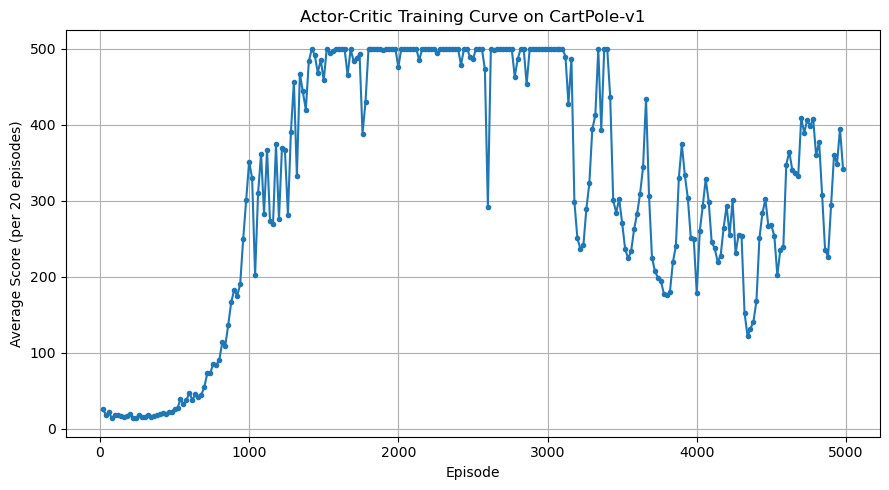

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))
plt.plot(epi_list, avg_score_list, marker='o', markersize=3)
plt.xlabel("Episode")
plt.ylabel(f"Average Score (per {20} episodes)")
plt.title("Actor-Critic Training Curve on CartPole-v1")
plt.grid(True)
plt.tight_layout()
plt.show()


---------------실패선(이 밑으로는 실패한 선 에러 이슈)-------------

In [2]:
import gym
import torch
from torch.distributions import Categorical
import time

# 학습된 model 그대로 사용
env = gym.make("CartPole-v1", render_mode="human")

s, _ = env.reset()
done = False
total_reward = 0

while not done:
    with torch.no_grad():
        prob = model.pi(torch.from_numpy(s).float())
        m = Categorical(prob)
        a = m.sample().item()

    s, r, done, truncated, info = env.step(a)
    total_reward += r
    time.sleep(0.02)  # 너무 빠르면 어지러움 방지용

env.close()
print("Total reward:", total_reward)


C:\Users\user1\anaconda3\envs\masan\lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


NameError: name 'model' is not defined